In [1]:
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import requests
import lxml
import webbrowser

import pandas as pd
import numpy as np
import re
import string

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

import gensim
from gensim.models import Word2Vec

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt


import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luisz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\luisz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luisz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\luisz\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
url = 'https://www.ign.com/reviews/movies'

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

html_text = requests.get(url, headers=headers).text

In [3]:
soup = BeautifulSoup(html_text, 'lxml')
main = soup.find('main', {"id": 'main-content'})
sections = main.section

In [4]:
figcaption_elements = soup.findAll('figcaption')

figcaption_values = []
for figcaption_element in figcaption_elements:
    figcaption_value = figcaption_element.text
    figcaption_values.append(figcaption_value)

In [5]:
figcaption_values

['7', '7', '6', '7', '8', '7', '7', '4', '4', '6', '4']

In [6]:
review_links = soup.find_all('a', class_='item-body')

hrefs = []
for review_link in review_links:
    href = review_link.get('href')
    hrefs.append(href)

In [7]:
hrefs

['/articles/david-holmes-the-boy-who-lived-review-harry-potter-documentary',
 '/articles/its-a-wonderful-knife-review',
 '/articles/the-hunger-games-the-ballad-of-songbirds-and-snakes-review',
 '/articles/the-marvels-review-brie-larson-samuel-l-jackson-mcu',
 '/articles/divinity-review-bella-thorne-eddie-alcazar',
 '/articles/the-killer-review-david-fincher-michael-fassbender-netflix',
 '/articles/five-nights-at-freddys-review',
 '/articles/freelance-review-john-cena-alison-brie',
 '/articles/cobweb-geomijip-review-song-kang-ho-kim-jee-woon',
 '/articles/the-end-we-start-from-review-jodie-comer']

In [8]:
base_url = 'https://www.ign.com'
data_from_urls = []

for href, score in zip(hrefs, figcaption_values):
    full_url = urljoin(base_url, href)
    response = requests.get(full_url, headers=headers)
    html_text = response.text
    soup = BeautifulSoup(html_text, 'lxml')
    page_title = soup.title.text
    paragraphs = soup.find_all('p', class_='jsx-3649800006')

    for paragraph in paragraphs:
        data_from_urls.append({'Title': page_title, 'Score': score, 'Paragraph': paragraph.text})


In [9]:
df = pd.DataFrame(data_from_urls)

In [10]:
df.head()

,Title,Score,Paragraph
0,David Holmes: The Boy Who Lived Review - IGN,7,David Holmes: The Boy Who Lived premieres Nove...
1,David Holmes: The Boy Who Lived Review - IGN,7,It's been 12 years since the release of Harry ...
2,David Holmes: The Boy Who Lived Review - IGN,7,Enter the documentary David Holmes: The Boy Wh...
3,David Holmes: The Boy Who Lived Review - IGN,7,Thus The Boy Who Lived serves two purposes: to...
4,David Holmes: The Boy Who Lived Review - IGN,7,"For fans of the franchise, its star, and cinem..."


In [11]:
df[df['Paragraph']==' ']

,Title,Score,Paragraph


In [12]:
df.replace(' ', np.nan, inplace=True)

In [13]:
df.dropna(subset=['Paragraph'], inplace=True)

In [14]:
def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    tokens = nltk.word_tokenize(text)
    
    return tokens

In [15]:
def remove_stopWords(tokens):
    stopWords = set(stopwords.words('english'))
    filtered_tokens = [words for words in tokens if words not in stopWords]
    return filtered_tokens

In [16]:
def lemmatization(tokens):
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

In [17]:
def remove_proper_names(tokens):
    tagged_tokens = pos_tag(tokens)
    filtered_tokens = [token[0] for token in tagged_tokens if token[1] != 'NNP']
    return filtered_tokens

In [18]:
def clean_text(text):
    tokens = preprocess_text(text)
    filtered_tokens = remove_stopWords(tokens)
    lemmatization_tokens = lemmatization(filtered_tokens)
    non_proper_name_tokens = remove_proper_names(filtered_tokens)
    clean_text = ' '.join(non_proper_name_tokens)
    return clean_text

In [19]:
df['cleaned_Paragraph'] = df['Paragraph'].apply(clean_text)

In [20]:
df.head()

,Title,Score,Paragraph,cleaned_Paragraph
0,David Holmes: The Boy Who Lived Review - IGN,7,David Holmes: The Boy Who Lived premieres Nove...,david holmes boy lived premieres november pm e...
1,David Holmes: The Boy Who Lived Review - IGN,7,It's been 12 years since the release of Harry ...,years since release harry potter deathly hallo...
2,David Holmes: The Boy Who Lived Review - IGN,7,Enter the documentary David Holmes: The Boy Wh...,enter documentary david holmes boy lived somew...
3,David Holmes: The Boy Who Lived Review - IGN,7,Thus The Boy Who Lived serves two purposes: to...,thus boy lived serves two purposes celebrate h...
4,David Holmes: The Boy Who Lived Review - IGN,7,"For fans of the franchise, its star, and cinem...",fans franchise star cinema general abundance b...


In [21]:
del df['Paragraph']

In [22]:
df.head()

,Title,Score,cleaned_Paragraph
0,David Holmes: The Boy Who Lived Review - IGN,7,david holmes boy lived premieres november pm e...
1,David Holmes: The Boy Who Lived Review - IGN,7,years since release harry potter deathly hallo...
2,David Holmes: The Boy Who Lived Review - IGN,7,enter documentary david holmes boy lived somew...
3,David Holmes: The Boy Who Lived Review - IGN,7,thus boy lived serves two purposes celebrate h...
4,David Holmes: The Boy Who Lived Review - IGN,7,fans franchise star cinema general abundance b...


# Analyzing the Data

In [23]:
print(f'Worst reviews: \n{df.groupby("Title")["Score"].max().sort_values().head(3)}')
print()
print(f'Best reviews: \n{df.groupby("Title")["Score"].max().sort_values(ascending=False).head(3)}')


Worst reviews: 
Title
Cobweb (Geomijip) Review - IGN        4
Freelance Review - IGN                4
The End We Start From Review - IGN    6
Name: Score, dtype: object

Best reviews: 
Title
Divinity Review - IGN                           8
David Holmes: The Boy Who Lived Review - IGN    7
Five Nights at Freddy's Review - IGN            7
Name: Score, dtype: object


## Word Cloud

In [24]:
text = " ".join(i for i in df.cleaned_Paragraph)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

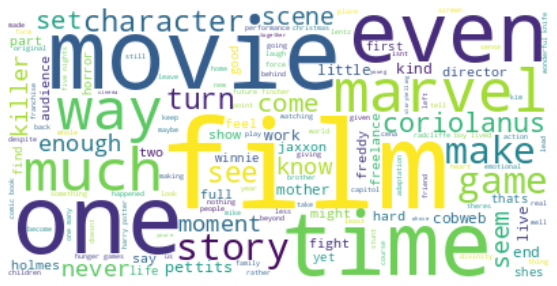

In [29]:
plt.figure( figsize=(15,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [34]:
words_to_remove = ['set', 'even', 'part', 'way', 'end', 'one', 'just', 'make', 'see', 'thats']

def remove_words(text):
    for word in words_to_remove:
        text = text.replace(word, '')
    return text

df['cleaned_Paragraph'] = df['cleaned_Paragraph'].apply(remove_words)

def remove_single_character_words(text):
    return ' '.join(word for word in text.split() if len(word) > 1)

df['cleaned_Paragraph'] = df['cleaned_Paragraph'].apply(remove_single_character_words)

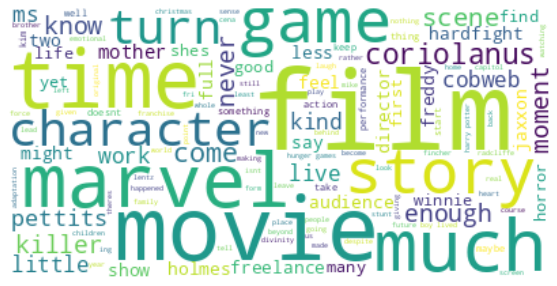

In [35]:
text = " ".join(i for i in df.cleaned_Paragraph)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

plt.figure( figsize=(15,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
//

SyntaxError: invalid syntax (411536581.py, line 1)

# Proving Models

In [ ]:
X = df['cleaned_Paragraph']
y = df['Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


### Support Vector Regression

In [ ]:
sv_model = SVR(kernel='linear')  # There are many different kernels like 'linear', 'rbf', etc.

# Train the model
sv_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_sv = sv_model.predict(X_test_tfidf)

#IGN Scores are Integers
y_pred_sv = np.around(y_pred_sv,0)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_sv)
r_squared = r2_score(y_test, y_pred_sv)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r_squared}')

In [ ]:
print(y_pred_sv)
print(np.array(y_test))

### Random Forest

In [ ]:
rf_model = RandomForestRegressor(n_estimators=150, random_state=42, max_depth=10)

# Train the model
rf_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_tfidf)

#IGN Scores are Integers
y_pred_sv = np.around(y_pred_rf,0)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r_squared_rf = r2_score(y_test, y_pred_rf)

print(f'Mean Squared Error (Random Forest): {mse_rf}')
print(f'R-squared (Random Forest): {r_squared_rf}')

In [ ]:
print(np.around(y_pred_rf,0))
print(np.array(y_test))

## Grid Searches

### SVR

In [ ]:
# Define the parameter grid for SVR
svr_param_grid = {'C': [0.1, 1, 10],
                  'kernel': ['linear', 'rbf', 'poly'],
                  'gamma': ['scale', 'auto']}

# Create the SVR model
svr_model = SVR()

# Create GridSearchCV for SVR
svr_grid_search = GridSearchCV(svr_model, svr_param_grid, cv=5, scoring='neg_mean_squared_error')
svr_grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and model
best_svr_params = svr_grid_search.best_params_
best_svr_model = svr_grid_search.best_estimator_

# Predict on the test set
y_pred_svr = best_svr_model.predict(X_test_tfidf)

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)
r_squared_svr = r2_score(y_test, y_pred_svr)

print("Best parameters for SVM:", best_svr_params)
print(f'Mean Squared Error (SVM): {mse_svr}')
print(f'R-squared (SVM): {r_squared_svr}')


### Random Forest

In [ ]:
# Define the parameter grid for Random Forest
rf_param_grid = {'n_estimators': [50, 100, 150],
                 'max_depth': [None, 10, 20, 30],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 2, 4]}

# Create the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Create GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and model
best_rf_params = rf_grid_search.best_params_
best_rf_model = rf_grid_search.best_estimator_

# Predict on the test set
y_pred_rf_gs = best_rf_model.predict(X_test_tfidf)

# Evaluate the model
mse_rf_gs = mean_squared_error(y_test, y_pred_rf_gs)
r_squared_rf_gs = r2_score(y_test, y_pred_rf_gs)

print("Best parameters for Random Forest:", best_rf_params)
print(f'Mean Squared Error (Random Forest): {mse_rf_gs}')
print(f'R-squared (Random Forest): {r_squared_rf_gs}')


## Pipelines

### Naive Bayes

In [ ]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

In [ ]:
df['Score'].unique()

In [ ]:
y_pred_nb = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred_nb, y_test))
print(classification_report(y_test, y_pred_nb,target_names= df['Score'].unique()))

In [ ]:
print(np.around(y_pred_rf,0))
print(np.array(y_test))

### Linear Support Vector Machine

In [ ]:
svm = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
svm.fit(X_train, y_train)

In [ ]:
y_pred_svm = svm.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred_svm, y_test))
print(classification_report(y_test, y_pred_svm,target_names=df['Score'].unique()))

In [ ]:
print(y_pred_svm)
print(np.array(y_test))